# Libraries & Helpers

In [1]:
# Libraries
import os
os.chdir("../..")

import pandas as pd
import numpy as np
import gspread
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from src import config
from src import help_functions as hf

# Configs
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Data

In [2]:
# Import and quick check Training data 
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[0], sheet_index=0)

# "Clean" data
training_data = hf.data_safe_convert_to_numeric(training_data)

# Date & Datetime
training_data["Date"] = pd.to_datetime(training_data[["Year", "Month", "Day"]]).dt.date
training_data["Datetime"] = pd.to_datetime(training_data[["Year", "Month", "Day"]])
training_data = training_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Training data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(training_data["Date"].min(), training_data["Date"].max()))
print("Duplicated rows = {}".format(training_data[training_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=training_data["Date"].min(), end=training_data["Date"].max()).date if d not in training_data["Date"].values]))

print("\nDifferent activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    training_data
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Training data about:
-----------------------------------------------------
Todays date: 2025-09-10
Date range: 2024-09-13 to 2025-09-09
Duplicated rows = 0
Missing dates = []

Different activities and their counts:
-------------------------------------
Trail Running ~> 295.93 hours (159 act.)
Road Biking ~> 82.91 hours (34 act.)
Running ~> 79.24 hours (77 act.)
Indoor Biking ~> 71.04 hours (51 act.)
Mountain Biking ~> 16.99 hours (9 act.)
Hiking ~> 15.35 hours (6 act.)
Road biking ~> 3.74 hours (2 act.)
Indoor Cycling ~> 1.50 hours (1 act.)
Lap Swimming ~> 0.21 hours (1 act.)


In [3]:
# Import and quick check Daily data
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
daily_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[1], sheet_index=0)

# "Clean" data
daily_data = hf.data_safe_convert_to_numeric(daily_data)

# Date & Datetime
daily_data["Date"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]]).dt.date
daily_data["Datetime"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]])
daily_data = daily_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Daily data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(daily_data["Date"].min(), daily_data["Date"].max()))
print("Duplicated rows = {}".format(daily_data[daily_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_data["Date"].min(), end=daily_data["Date"].max()).date if d not in daily_data["Date"].values]))

Daily data about:
-----------------------------------------------------
Todays date: 2025-09-10
Date range: 2024-04-15 to 2025-09-09
Duplicated rows = 0
Missing dates = []


# Goals

We have two goals:

1. **Recent Adjusted Relative Training Load (ARTL)**

Define a simple metric that shows where we are with our current training compared to what we've been doing in the recent past. The purpose is to see if we should reduce out trainings load — so that we don't overreach or risk injury, or increase increase it to match what what our body has been adapted to in recent past. Or just simple define where in the training cycle we are if we take larger picture into account. *How are we positined relative to recent training load overall?*

2. **Recent Load Relative Percentile (RLRP)**

Quantify how hard today's training was compared to what we are used to. In other words, show where this session fall within the distribution of our recent sessions — is it an average day, a light day, or a clear spike? This also helps guide tomorrow’s (or few next days) training choice, since we know whether today was relatively light, normal, or heavy.

Dataset:

- All activities, regardless if it was real training or not (including hiking, swimming, easy cycling etc.).
- Lets assume we only have one "real" workout per day and take total (sum) daily training load (one sample is one day). 

Let $TL_i$ be the training load of the day i.

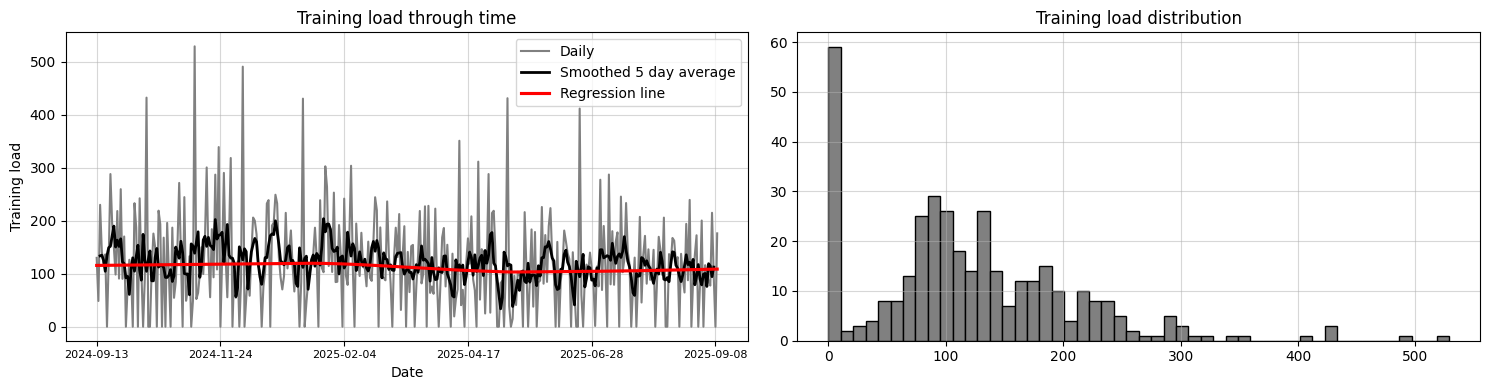

    Datetime  Training load                     Description
0 2025-04-12          350.6        Race Zalec Trail Running
1 2025-06-21          411.3       Race Tolmin Trail Running
2 2025-01-11          430.0      Race Nazarje Trail Running
3 2025-05-10          430.8       Race Idrija Trail Running
4 2024-10-12          431.9        Race Zalec Trail Running
5 2024-12-07          490.3      Race Velenje Trail Running
6 2024-11-09          528.6  Race Nova Gorica Trail Running


In [4]:
# Data:

rtl_data = (
    training_data
    .groupby("Datetime")
    .agg({
        "Training load": "sum",
        "Distance [km]": "sum",
        "Duration [h]": "sum",
        "Activity type": lambda x: " | ".join(map(str, x)),  
        "Description": lambda x: " | ".join(x)  
    })
    .reset_index()
    .assign(**{"Date index": lambda x: np.arange(x.shape[0])[::-1] + 1})
    # [["Date", "Training load"]]
)

# Exploratory data analysis - EDA
fig, ax = plt.subplots(1,2,figsize=(15, 4))
indices = np.arange(rtl_data.shape[0])

# Training load trough time
ax[0].set_title("Training load through time")
ax[0].plot(indices, rtl_data["Training load"], color="grey", label="Daily")
ax[0].plot(indices, rtl_data["Training load"].rolling(window=5, center=True).mean(), color="black", label="Smoothed 5 day average", linewidth=2)
sns.regplot(x=indices, y=rtl_data["Training load"], scatter=False, lowess=True, color="red", label="Regression line", ax=ax[0])
ax[0].legend()

ax[0].set_xticks(indices[::max(1, len(indices)//5)])  
ax[0].set_xticklabels(rtl_data["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Training load")

# Training load distribution
ax[1].set_title("Training load distribution")
ax[1].hist(rtl_data["Training load"], bins=50, color="grey", edgecolor="black")

for i in [0,1]:
    ax[i].grid(alpha=.5)
        
plt.tight_layout()
plt.show()

print(
    rtl_data
    .sort_values("Training load")
    [["Datetime", "Training load", "Description"]]
    .tail(7)
    .reset_index(drop=True)
)



# History-Aware Stratified Relative Training Load (HASRTL)
---
---

### Idea

When training for endurance sports, our bodies adapt over time, and whether a workout is "hard" or "easy" on the body, depends on what we’ve been doing recently and historically. To capture this, we define a **history-aware measure of current relative load**, which compares the recent training patterin to what the athlete's body has successfully adapted to over a longer baseline period.

We can think of this in two complementary components:

- Baseline (long term) adaptation - Load the body has been succesfully adapted to over a longer period, assuming this distribution is "safe", disregarding recent acute load.
    - Denoted as $TL_{\text{baseline},t}$.
    - Computed over a long baseline window of $N$ days, excluding last $n$ days: $\mathcal{L}_t=\{TL_{t-(n+j)}\mid j=1,\dots, N\}$ 
    - To give more importance to recent training within the baseline period, we assign weights decreasing with days: $w_j = \lambda^{j-1}, \quad 0 < \lambda <= 1, \quad j = 1, ..., N$, where more recent baseline days contribute more to defining the baseline load.

- Recent training pattern - Load the body is currently being exposed to, capturing acute training load.
    - Denotes $TL_{\text{recent},t}$.
    - Computed over a recent window of $n$ days: $\mathcal{R}_t=\{TL_{t-j}\mid j=1,\dots,n\}$.
    - This can also be weighted to emphasize the most recent sessions: $v_j = \lambda^{j-1}, \quad 0 < \lambda <= 1, \quad j = 1, ..., n$

We define the parameters as:
- Baseline window: N = 90 days
- Recent window: n = 14 days
- Weight base $\lambda$ = $(0.5)^\frac{1}{31} = 0.978$, so weight halves approximately every 31 days.

Additionaly: Because we aim to capture relative load patterns rather than total accumulated load, we normalize the weights so that they sum to 1. This ensures that the weighted, for example averages, for baseline and recent windows are directly comparable: 

- $\overline{w}_j = \frac{w_j}{\sum_{k=1}^{N}w_k} \quad j = 1, ..., N$
- $\overline{v}_j = \frac{v_j}{\sum_{k=1}^{v}w_k} \quad j = 1, ..., v$

Note: By keeping the baseline and recent windows non-overlapping, we ensure that the baseline reflects only training the body has already adapted to, without being influenced by recent sessions that the body has not yet adjusted to. This allows us to identify increases in stress in the recent window that may pose a risk.

In [5]:
# Define parameters
baseline_window = 90
recent_window = 21
lambda_base = 0.978

In [6]:
# Define weights once for all
baseline_window_days = range(1, baseline_window+1)
baseline_window_weights = np.array([lambda_base ** (j-1) for j in baseline_window_days])
baseline_window_normalized_weights = baseline_window_weights / sum(baseline_window_weights)

recent_window_days = range(1, recent_window+1)
recent_window_weights = np.array([lambda_base ** (j-1) for j in recent_window_days])
recent_window_normalized_weights = recent_window_weights / sum(recent_window_weights)

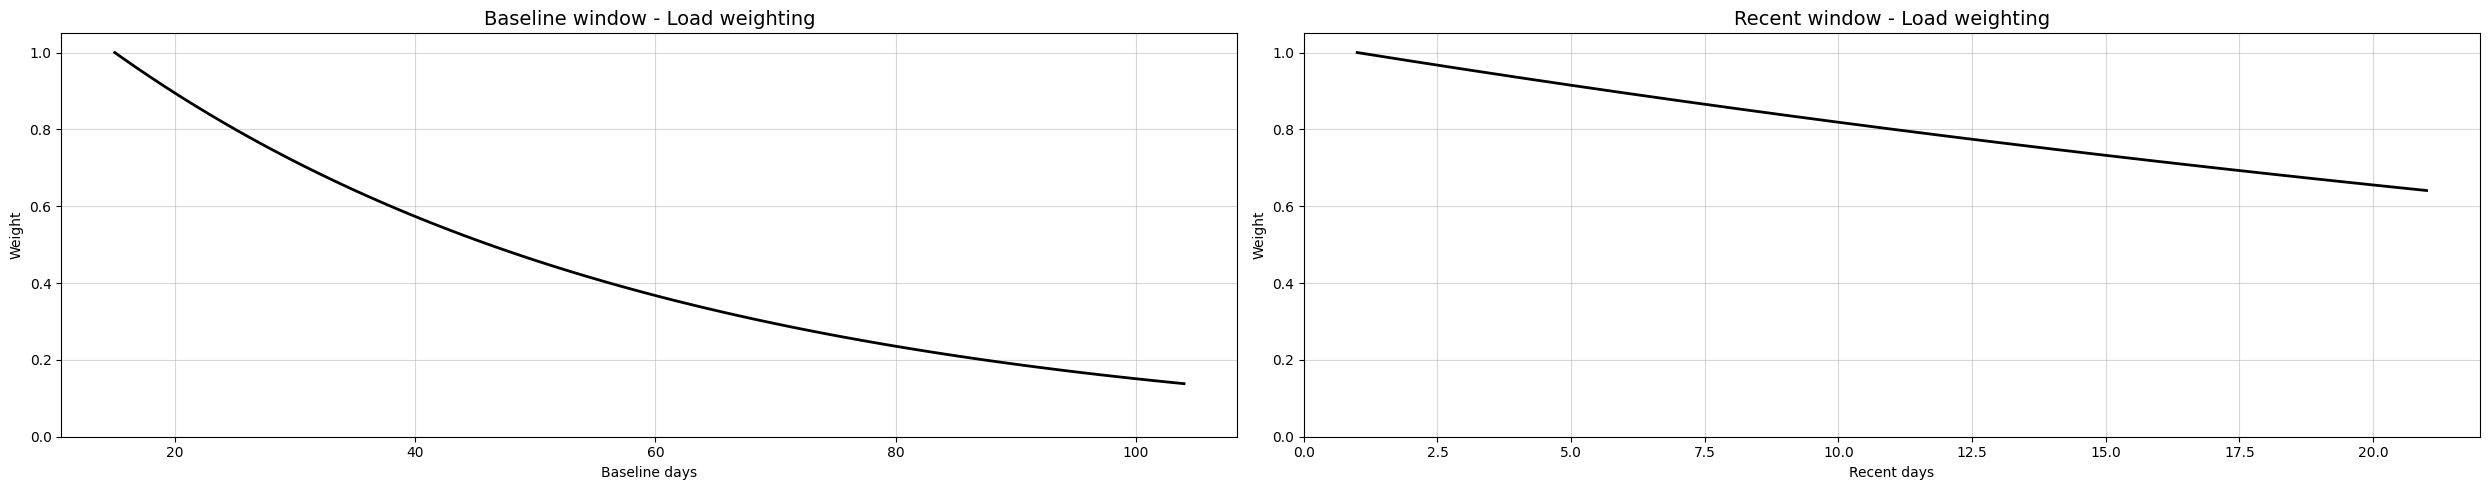

In [7]:
# How do we weight the days?

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].set_title("Baseline window - Load weighting", fontsize=14)
baseline_window_days = range(1, baseline_window+1)
baseline_window_weights = np.array([lambda_base ** (j-1) for j in baseline_window_days])
# baseline_window_normalized_weights = baseline_window_weights / sum(baseline_window_weights)
ax[0].plot(np.repeat(14, 90) + baseline_window_days, baseline_window_weights, color="black", linewidth=2)
ax[0].set_xlabel("Baseline days")


ax[1].set_title("Recent window - Load weighting", fontsize=14)
recent_window_days = range(1, recent_window+1)
recent_window_weights = np.array([lambda_base ** (j-1) for j in recent_window_days])
# recent_window_normalized_weights = recent_window_weights / sum(recent_window_weights)
ax[1].plot(recent_window_days, recent_window_weights, color="black", linewidth=2)
ax[1].set_xlabel("Recent days")

for i in [0,1]:
    ax[i].set_ylim(0,1.05)
    ax[i].set_ylabel("Weight")
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

### Percentile stratified metric

In endurance sports, training days (including races) can be grouped into a few main types:
- **Easy & medium long sessions** - used for recovery, aerobic base, and technique work. These make up roughly 70% of all sessions.
- **Hard sessions** - tempo, threshold, VO2max, or interval workouts. Typically around 20% of sessions.
- **Long days** - the occasional very long run, bike ride, or race that forms the extreme right tail of the distribution. About 10% of sessions.
- **Other** - longer bike days, longer hikes, multiple activities in one day etc.
- **Rest days** - no training at all.

In [8]:
# Define easy, hard and long days ~ cca (hard to trully distinct them)
rtl_data["easy_hard_long_description"] = pd.Series(dtype="object")

# Rest days
rest_mask = rtl_data["Description"] == "Rest"
rtl_data.loc[rest_mask, "easy_hard_long_description"] = "rest"

# Eays days (No special description, duration < 1.5h)
easy_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"].str.contains("Running|Workout|Biking|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) &
    ~(rtl_data["Description"].str.contains("Race", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[easy_mask, "easy_hard_long_description"] = "easy"

# Hard days (Special description, duration < 2h)
hard_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"] .str.contains("INT|TT|PWH|LT|x")) &
    ~(rtl_data["Description"].str.contains("Running|Biking|Workout|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[hard_mask, "easy_hard_long_description"] = "hard"

# Long days (No special description, duration >= 2h)
long_mask = (
    (rtl_data["Duration [h]"] >= 2.0)  &
    (rtl_data["Description"].str.contains("Running|Dolgi|Tek|x", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[long_mask, "easy_hard_long_description"] = "long"

# Other (medium long days, other ...)
other_mask = (
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[other_mask, "easy_hard_long_description"] = "other"

In [9]:
# About
print("Easy, hard, long days - description:")
print("-----------------------------------------------------")
for value in ["easy", "hard", "long", "other", "rest"]:
    data_tmp = rtl_data.query("easy_hard_long_description == @value")
    print("{} ~> {} ({}% | *{}%) ~> [mean = {}, SD = {}]".format(
        value, 
        data_tmp.shape[0],
        round(data_tmp.shape[0]/rtl_data.shape[0] * 100, 2),
        round(data_tmp.shape[0]/rtl_data.query("easy_hard_long_description != 'rest'").shape[0] * 100, 2),
        round(data_tmp["Training load"].mean(), 2),
        round(data_tmp["Training load"].std(), 2)
        ))
print("* ~> Without rest days included in proportions")

Easy, hard, long days - description:
-----------------------------------------------------
easy ~> 168 (46.41% | *54.02%) ~> [mean = 95.79, SD = 43.01]
hard ~> 52 (14.36% | *16.72%) ~> [mean = 189.49, SD = 55.69]
long ~> 67 (18.51% | *21.54%) ~> [mean = 217.18, SD = 96.04]
other ~> 24 (6.63% | *7.72%) ~> [mean = 130.32, SD = 67.2]
rest ~> 51 (14.09% | *16.4%) ~> [mean = 0.0, SD = 0.0]
* ~> Without rest days included in proportions


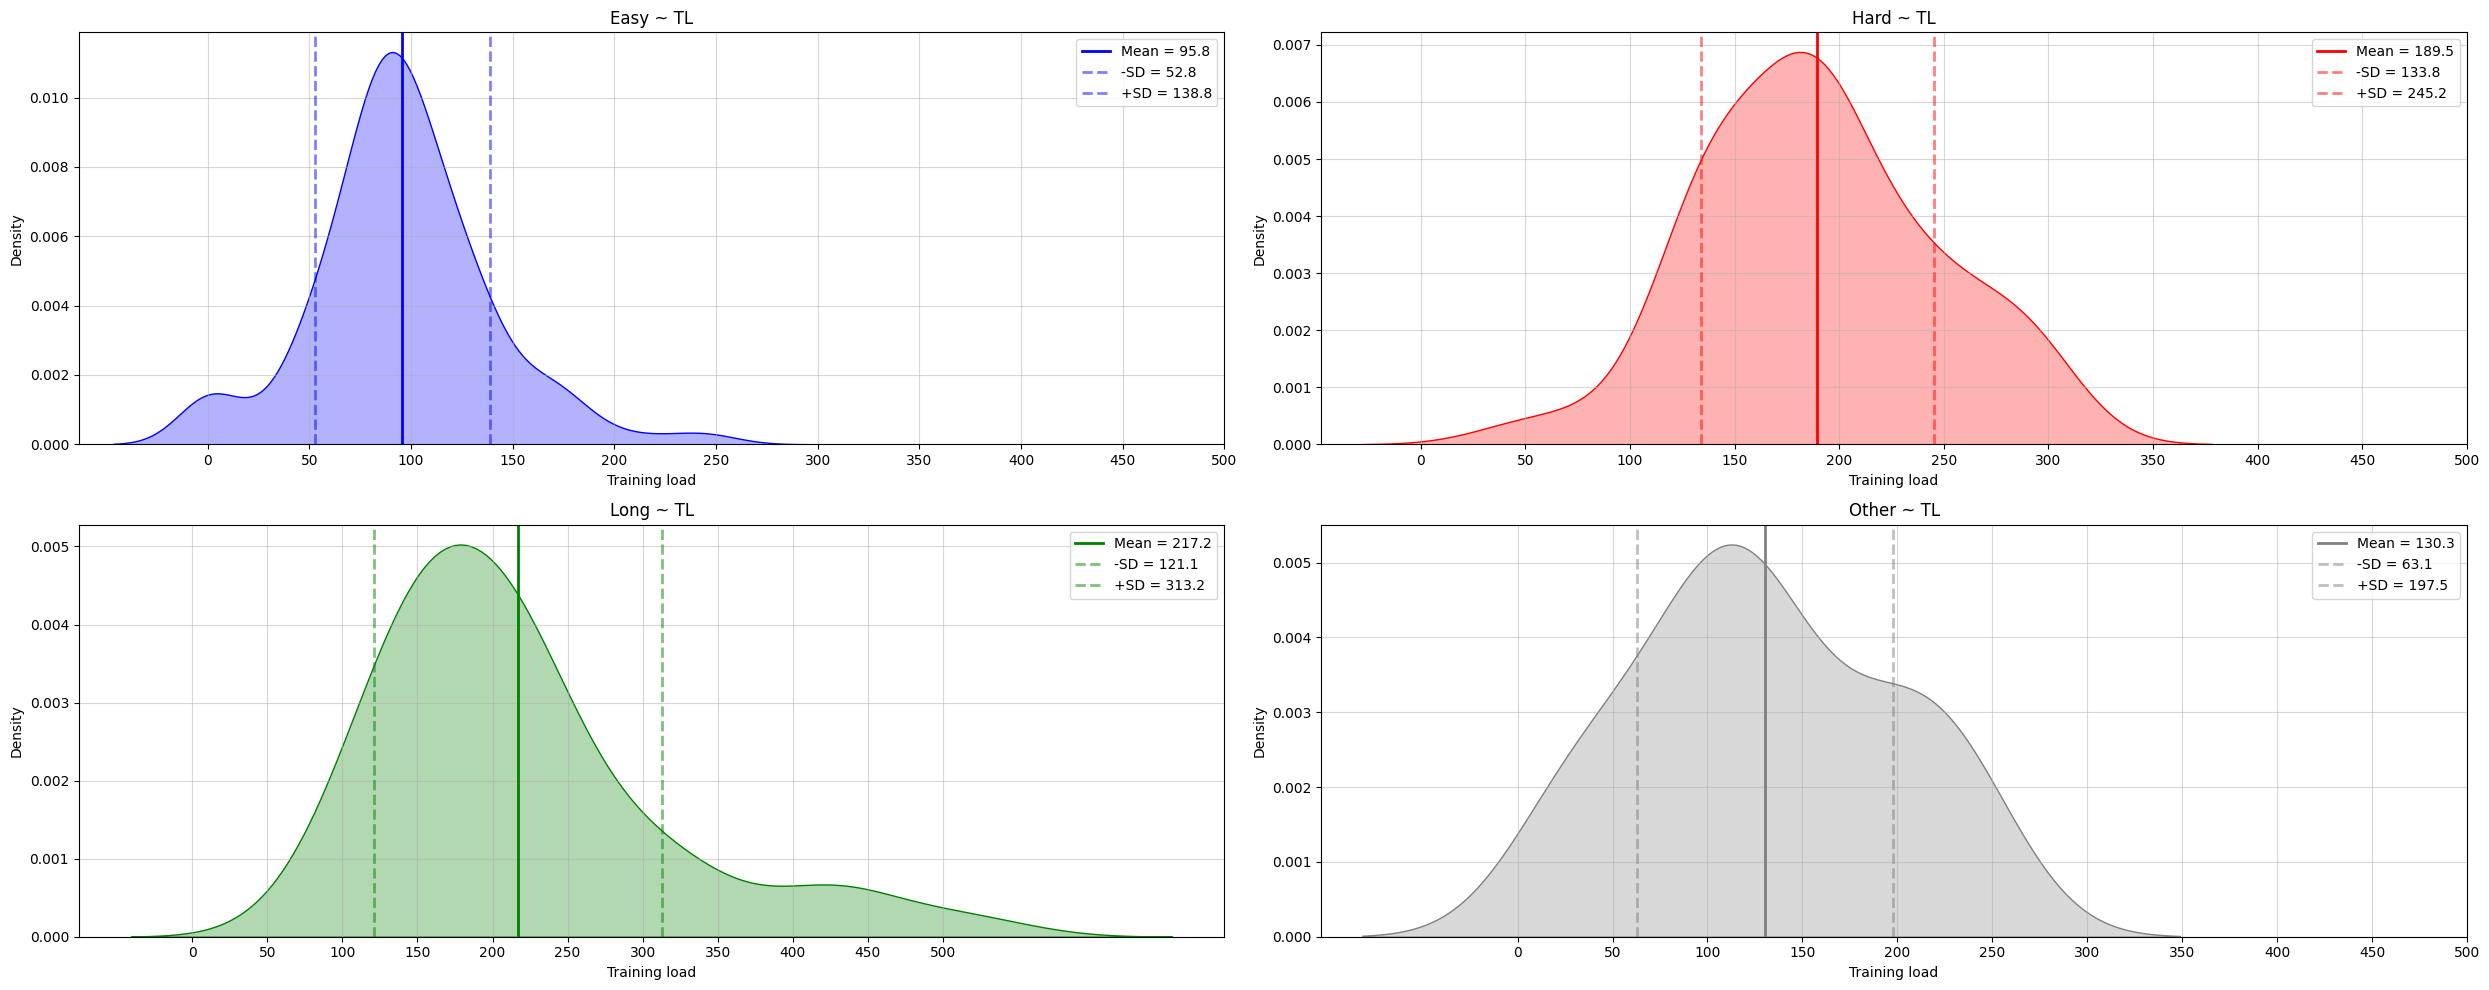

In [10]:
# Plot 1
fig, ax = plt.subplots(2,2,figsize=(25, 10))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long", "other"]

ax[0,0].set_title("Easy ~ TL")
easy_tmp = rtl_data.query("easy_hard_long_description == 'easy'")["Training load"]
sns.kdeplot(easy_tmp, color="blue", fill=True, alpha=0.3, ax=ax[0,0])
ax[0,0].axvline(easy_tmp.mean(), color="blue", linestyle="-", linewidth=2, label=f"Mean = {easy_tmp.mean():.1f}")
ax[0,0].axvline(easy_tmp.mean() - easy_tmp.std(), color="blue", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {easy_tmp.mean() - easy_tmp.std():.1f}")
ax[0,0].axvline(easy_tmp.mean() + easy_tmp.std(), color="blue", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {easy_tmp.mean() + easy_tmp.std():.1f}")

ax[0,1].set_title("Hard ~ TL")
hard_tmp = rtl_data.query("easy_hard_long_description == 'hard'")["Training load"]
sns.kdeplot(hard_tmp, color="red", fill=True, alpha=0.3, ax=ax[0,1])
ax[0,1].axvline(hard_tmp.mean(), color="red", linestyle="-", linewidth=2, label=f"Mean = {hard_tmp.mean():.1f}")
ax[0,1].axvline(hard_tmp.mean() - hard_tmp.std(), color="red", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {hard_tmp.mean() - hard_tmp.std():.1f}")
ax[0,1].axvline(hard_tmp.mean() + hard_tmp.std(), color="red", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {hard_tmp.mean() + hard_tmp.std():.1f}")

ax[1,0].set_title("Long ~ TL")
long_tmp = rtl_data.query("easy_hard_long_description == 'long'")["Training load"]
sns.kdeplot(long_tmp, color="green", fill=True, alpha=0.3, ax=ax[1,0])
ax[1,0].axvline(long_tmp.mean(), color="green", linestyle="-", linewidth=2, label=f"Mean = {long_tmp.mean():.1f}")
ax[1,0].axvline(long_tmp.mean() - long_tmp.std(), color="green", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {long_tmp.mean() - long_tmp.std():.1f}")
ax[1,0].axvline(long_tmp.mean() + long_tmp.std(), color="green", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {long_tmp.mean() + long_tmp.std():.1f}")

ax[1,1].set_title("Other ~ TL")
other_tmp = rtl_data.query("easy_hard_long_description == 'other'")["Training load"]
sns.kdeplot(other_tmp, color="grey", fill=True, alpha=0.3, ax=ax[1,1])
ax[1,1].axvline(other_tmp.mean(), color="grey", linestyle="-", linewidth=2, label=f"Mean = {other_tmp.mean():.1f}")
ax[1,1].axvline(other_tmp.mean() - other_tmp.std(), color="grey", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {other_tmp.mean() - other_tmp.std():.1f}")
ax[1,1].axvline(other_tmp.mean() + other_tmp.std(), color="grey", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {other_tmp.mean() + other_tmp.std():.1f}")

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))
        ax[i,j].grid(alpha=.5)
        ax[i,j].legend()

plt.tight_layout()
plt.show()

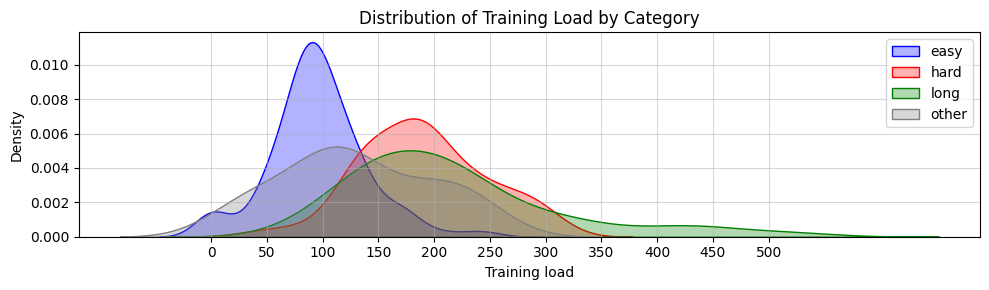

In [11]:
# Plot 2
fig, ax = plt.subplots(1,1, figsize=(10,3))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long", "other"]

for cat in categories:
    tmp = rtl_data.query("easy_hard_long_description == @cat")["Training load"]
    color = colors[cat]
    sns.kdeplot(tmp, color=color, fill=True, alpha=0.3, ax=ax, label=cat)

ax.set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))

ax.set_xlabel("Training load")
ax.set_ylabel("Density")
ax.set_title("Distribution of Training Load by Category")
ax.legend()

plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

To create a history-aware measure of current relative load, we have to take into account all of three types of sessions—easy, hard, and long, as they all contribute to our overall training load and adaptation, each in their own way. 
- Even though **easy and medium-long** sessions are individually low-stress, small increases in duration, intensity, or frequency can gradually accumulate, potentially pushing the body beyond its adapted baseline. They also form the foundation for recovery and adaptation from harder sessions, so they should not be too long, too intense, or too rare, ensuring that we can perform well in harder workouts.
- **Hard sessions** are important for performance improvement but carry higher risk of fatigue and overreaching. By tracking them separately, we can see if recent hard sessions exceed what the body is adapted to, indicating higher acute load. They should also make up a reasonable portion of total sessions to allow sufficient recovery.
- **Long days** are infrequent but highly taxing. Monitoring their frequency and intensity relative to baseline ensures they are not too frequent or extreme, reducing risk of excessive fatigue or injury.

We will divide all sessions into these three categories based on Training Load values. using percentiles to define the thresholds. This approach is individualized, automatic, and reproducible. The baseline rolling window is used to set the thresholds, which are then applied to both baseline and recent data.
- This ensures the baseline distribution reflects training the body has already adapted to, providing a safe reference.
- Recent sessions are evaluated relative to this safe baseline, so any increase in intensity, frequency, or duration signals higher acute load or potential risk.
- For example, "easy" sessions in the recent window cannot appear deceptively low simply because the recent training overall is harder than baseline.

Formally, let $\mathcal{Q}^w_p(\mathcal{L}_t)$ be weighted $p$-th quantile of the baseline window $\mathcal{L}_t$ using weights $w_j$ and

We define the baseline and recent buckets using baseline percentiles $q^w_{70,t}$ and $q^w_{90,t}$ as follows:
- **Easy sessions**: Training loads falling below the weighted $q_{low}$ percentile of the window - $TL \leq q^w_{low,t}=Q^w_{low}(\mathcal{L}_t)$ 
- **Hard sessions**: Training loads between the weighted $q_{low}$ and $q_{high}$ percentiles - $q^w_{70,t} < $ TL $\leq q^w_{high,t}=Q^w_{high}(\mathcal{L}_t)$
- **Long days**: Training loads above the weighted 90th percentile - $TL > q^w_{high,t}=Q^w_{high}(\mathcal{L}_t)$

**Note on weighted percentiles**: The weighted percentile represents the TL at which the cumulative sum of weights reaches the desired fraction of total weight. This accounts for the fact that more recent baseline sessions contribute more to the threshold.

Having defined these buckets, we summarize each bucket by the weighted average training load within, where we allow more recent training days to contribute more to the bucket averages. With this, we make the metric sensitive to shifts in the typical intensity of each type of session within the bucket. 

Let $w_j$ be the weight of day $j$ in the baseline window $\mathcal{L}_t$ and $v_j$ be the weight of day $j$ in the recent window $\mathcal{R}_t$. We then define the weighted averages within each bucket as:

**Baseline bucket weighted averages:**
- Easy: $\mu^w_{1,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{L}_t,\; TL \le q^w_{low,t}\,]$
- Hard: $\mu^w_{2,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{L}_t,\; q^w_{low,t} < TL \le q^w_{high,t}\,]$
- Long: $\mu^w_{3,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{L}_t,\; TL > q^w_{high,t}\,]$

**Recent bucket weighted averages:**
- Easy: $\nu^w_{1,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{R}_t,\; TL \le q^w_{low,t}\,]$
- Hard: $\nu^w_{2,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{R}_t,\; q^w_{low,t} < TL \le q^w_{high,t}\,]$
- Long: $\nu^w_{3,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{R}_t,\; TL > q^w_{high,t}\,]$

Where $\mathbb{E}[\cdot]$ denotes the empirical weighted mean $\mathbb{E}_w[v] = \frac{\sum_{i=1}^nw_iv_i}{\sum_{i=1}^nw_i}$ over the subset of training load values falling into the specified bucket.

In addition to the weighted averages, we can also track the proportion of sessions falling into each bucket in both the baseline and the recent window, as the number of easy, hard, and long sessions is not fixed once baseline thresholds are applied to recent training. For example, if the proportion of easy days decreases in recent window  may signal insufficient recovery. Formally, let:

$\pi_{k,t}^{(b)}$ and $\pi_{k,t}^{(r)}$ 

denote proportions of sessions in bucket $k = 1,2,3$ in baseline and recent window respectively.

In [12]:
# Baseline buckets weighted average & Recent buckets weighted average ~ Incremental calculation ~> Helper functions 

# Weighted quantile
def weighted_quantile(values, weights, quantile):

    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]

    cumulative_normalized_weights  = np.cumsum(weights_sorted) / np.sum(weights_sorted)
    quantile_value = np.interp(quantile, cumulative_normalized_weights, values_sorted)

    return quantile_value

# Weighted mean
def weighted_mean(values, weights):

    if len(values) == 0:
        return 0.0

    sum_weighted_values = np.sum(values * weights)
    sum_weights = np.sum(weights)

    weighted_mean = 1/sum_weights * sum_weighted_values
    return weighted_mean

# Go on full data ~> Go on missing rows values
def update_baseline_recent_buckets_averages(df, baseline_window, baseline_weights, recent_window, recent_weights, quantile_low, quantile_high, agg_metric):

    # Check if df has columns, if not, create them
    metric_name = agg_metric.title().replace(" ", "")
    columns = [

        f"baseline_b1_{metric_name}_weighted_mean", 
        f"baseline_b2_{metric_name}_weighted_mean", 
        f"baseline_b3_{metric_name}_weighted_mean",

        f"baseline_b1_{metric_name}_proportion",
        f"baseline_b2_{metric_name}_proportion",
        f"baseline_b3_{metric_name}_proportion",

        f"recent_b1_{metric_name}_weighted_mean", 
        f"recent_b2_{metric_name}_weighted_mean", 
        f"recent_b3_{metric_name}_weighted_mean",

        f"recent_b1_{metric_name}_proportion",
        f"recent_b2_{metric_name}_proportion",
        f"recent_b3_{metric_name}_proportion",
    ]

    for col in columns:
        if col not in df.columns:
            df[col] = np.nan

    # Fill missing metrics values row by row ~ Baseline 
    baseline_mask = df[[f"baseline_b1_{metric_name}_weighted_mean", f"baseline_b2_{metric_name}_weighted_mean", f"baseline_b3_{metric_name}_weighted_mean"]].isna().any(axis=1)
    for idx in df.index[baseline_mask]:

        first_baseline_row = idx - baseline_window + 1
        last_baseline_row = idx

        # Do we have enough history?
        if (first_baseline_row >= 0):

            # Calculate baseline set ~> Values & descending Datetime order common to weights
            baseline_set = (
                df
                .loc[first_baseline_row : last_baseline_row, ["Datetime", agg_metric]]
                .sort_values("Datetime", ascending=False)
                [agg_metric]
                .reset_index(drop=True)
                )

            # Values & Weights for each bucket
            quantile_low_baseline = weighted_quantile(values=baseline_set, weights=baseline_weights, quantile=quantile_low)
            quantile_high_baseline = weighted_quantile(values=baseline_set, weights=baseline_weights, quantile=quantile_high)

            b1_baseline_set = baseline_set[baseline_set <= quantile_low_baseline]
            b1_baseline_weights = baseline_weights[baseline_set <= quantile_low_baseline]

            b2_baseline_set = baseline_set[(baseline_set > quantile_low_baseline) & (baseline_set <= quantile_high_baseline)]
            b2_baseline_weights = baseline_weights[(baseline_set > quantile_low_baseline) & (baseline_set <= quantile_high_baseline)]

            b3_baseline_set = baseline_set[baseline_set > quantile_high_baseline]
            b3_baseline_weights = baseline_weights[baseline_set > quantile_high_baseline]

            # Weighted means for each bucket
            df.at[idx, f"baseline_b1_{metric_name}_weighted_mean"] = weighted_mean(b1_baseline_set, b1_baseline_weights)
            df.at[idx, f"baseline_b2_{metric_name}_weighted_mean"] = weighted_mean(b2_baseline_set, b2_baseline_weights)
            df.at[idx, f"baseline_b3_{metric_name}_weighted_mean"] = weighted_mean(b3_baseline_set, b3_baseline_weights)

            # Proportions in each bucket
            df.at[idx, f"baseline_b1_{metric_name}_proportion"] = len(b1_baseline_set)/len(baseline_set)
            df.at[idx, f"baseline_b2_{metric_name}_proportion"] = len(b2_baseline_set)/len(baseline_set)
            df.at[idx, f"baseline_b3_{metric_name}_proportion"] = len(b3_baseline_set)/len(baseline_set)

    # Fill missing metrics values row by row ~ Recent 
    recent_mask = df[[f"recent_b1_{metric_name}_weighted_mean", f"recent_b2_{metric_name}_weighted_mean", f"recent_b3_{metric_name}_weighted_mean"]].isna().any(axis=1)
    for idx in df.index[recent_mask]:

        first_recent_row = idx - recent_window + 1
        last_recent_row = idx

        first_baseline_row_idx = idx - recent_window - baseline_window + 1
        last_baseline_row_idx = idx - recent_window

        # Do we have enough history?
        if (first_baseline_row_idx >= 0):

            # Baseline set and quantilers
            baseline_set_idx = (
                df
                .loc[first_baseline_row_idx : last_baseline_row_idx, ["Datetime", agg_metric]]
                .sort_values("Datetime", ascending=False)
                [agg_metric]
                .reset_index(drop=True)
                )
            
            qunatile_low_baseline_idx = weighted_quantile(values=baseline_set_idx, weights=baseline_weights, quantile=quantile_low)
            quantile_high_baseline_idx = weighted_quantile(values=baseline_set_idx, weights=baseline_weights, quantile=quantile_high)

            # Calculate recent set ~> Values & descending DateTime order common to weights
            recent_set = (
                df
                .loc[first_recent_row : last_recent_row, ["Datetime", agg_metric]]
                .sort_values("Datetime", ascending=False)
                [agg_metric]
                .reset_index(drop=True)
                )

            # Values for each bucket
            b1_recent_set = recent_set[recent_set <= qunatile_low_baseline_idx]
            b1_recent_weights = recent_weights[recent_set <= qunatile_low_baseline_idx]

            b2_recent_set = recent_set[(recent_set > qunatile_low_baseline_idx) & (recent_set <= quantile_high_baseline_idx)]
            b2_recent_weights = recent_weights[(recent_set > qunatile_low_baseline_idx) & (recent_set <= quantile_high_baseline_idx)]

            b3_recent_set = recent_set[recent_set > quantile_high_baseline_idx]
            b3_recent_weights = recent_weights[recent_set > quantile_high_baseline_idx]

            # Weighted means for each bucket
            df.at[idx, f"recent_b1_{metric_name}_weighted_mean"] = weighted_mean(b1_recent_set, b1_recent_weights)
            df.at[idx, f"recent_b2_{metric_name}_weighted_mean"] = weighted_mean(b2_recent_set, b2_recent_weights)
            df.at[idx, f"recent_b3_{metric_name}_weighted_mean"] = weighted_mean(b3_recent_set, b3_recent_weights)

            # Proportions in each bucket
            df.at[idx, f"recent_b1_{metric_name}_proportion"] = len(b1_recent_set)/len(recent_set)
            df.at[idx, f"recent_b2_{metric_name}_proportion"] = len(b2_recent_set)/len(recent_set)
            df.at[idx, f"recent_b3_{metric_name}_proportion"] = len(b3_recent_set)/len(recent_set)

    # Return
    return df

In [13]:
# Baseline buckets average and proportion & Recent buckets average and proportion ~ Incremental calculation ...

rtl_data = update_baseline_recent_buckets_averages(
    df = rtl_data, 
    baseline_window = baseline_window, 
    baseline_weights = baseline_window_normalized_weights,
    recent_window = recent_window, 
    recent_weights = recent_window_normalized_weights,
    quantile_low = 0.60,
    quantile_high = 0.85,
    agg_metric = "Training load"
    )

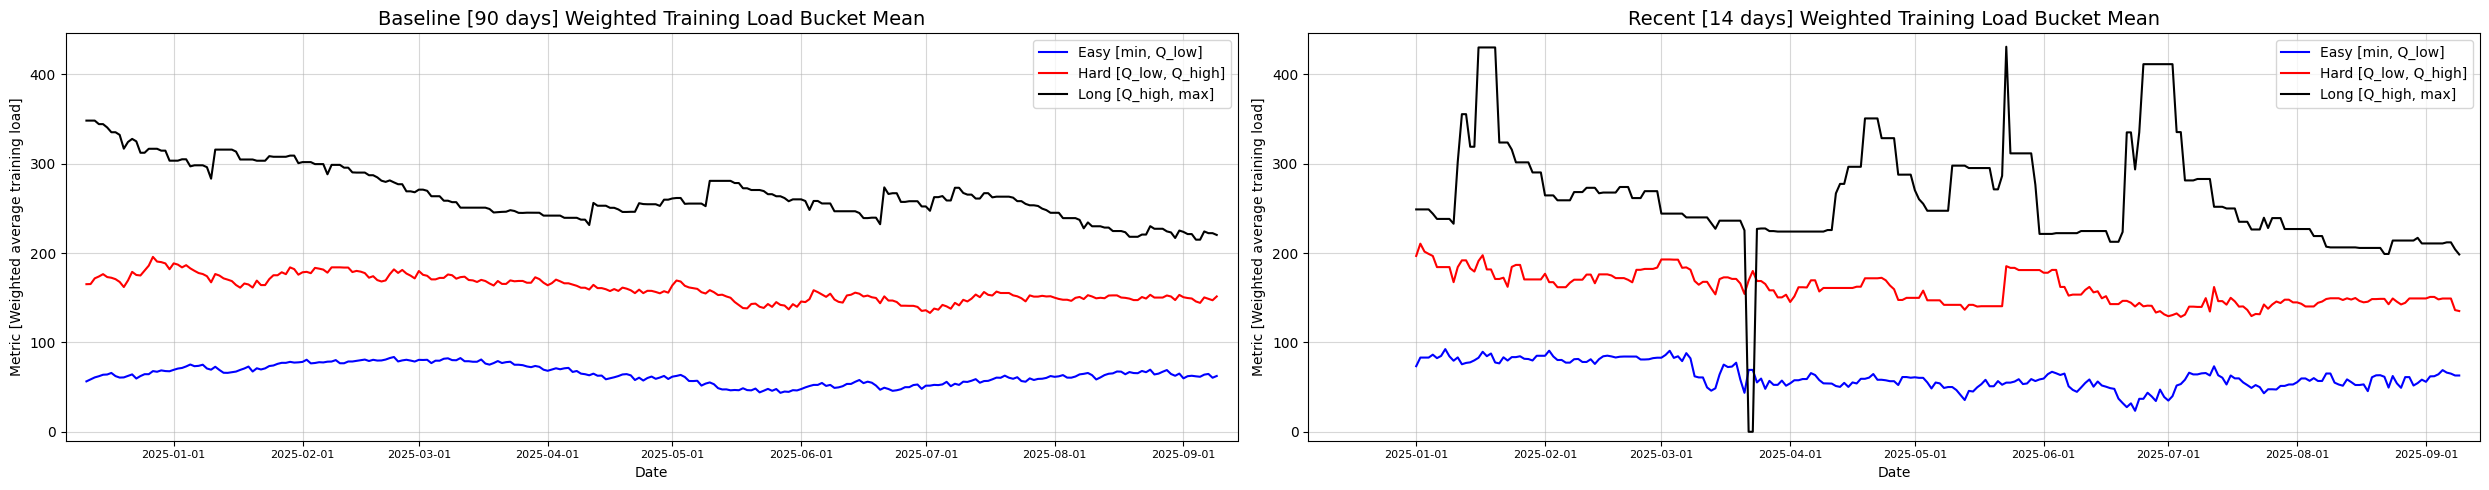

In [14]:
# Plots ~ Averages ~> Baseline & Recent

fig, ax = plt.subplots(1,2, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))
plot_data = rtl_data.loc[rtl_data["baseline_b1_TrainingLoad_weighted_mean"].notnull(), :]

ax[0].set_title("Baseline [90 days] Weighted Training Load Bucket Mean", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b1_TrainingLoad_weighted_mean"], color="blue", label="Easy [min, Q_low]")
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b2_TrainingLoad_weighted_mean"], color="red", label="Hard [Q_low, Q_high]")
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b3_TrainingLoad_weighted_mean"], color="black", label="Long [Q_high, max]")

ax[1].set_title("Recent [14 days] Weighted Training Load Bucket Mean", fontsize=14)
ax[1].plot(plot_data["Datetime"], plot_data["recent_b1_TrainingLoad_weighted_mean"], color="blue", label="Easy [min, Q_low]")
ax[1].plot(plot_data["Datetime"], plot_data["recent_b2_TrainingLoad_weighted_mean"], color="red", label="Hard [Q_low, Q_high]")
ax[1].plot(plot_data["Datetime"], plot_data["recent_b3_TrainingLoad_weighted_mean"], color="black", label="Long [Q_high, max]")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=5)))
    ax[i].set_ylim(-10,
                   pd.concat([plot_data["baseline_b3_TrainingLoad_weighted_mean"], plot_data["recent_b3_TrainingLoad_weighted_mean"]]).max() + 15)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Metric [Weighted average training load]")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

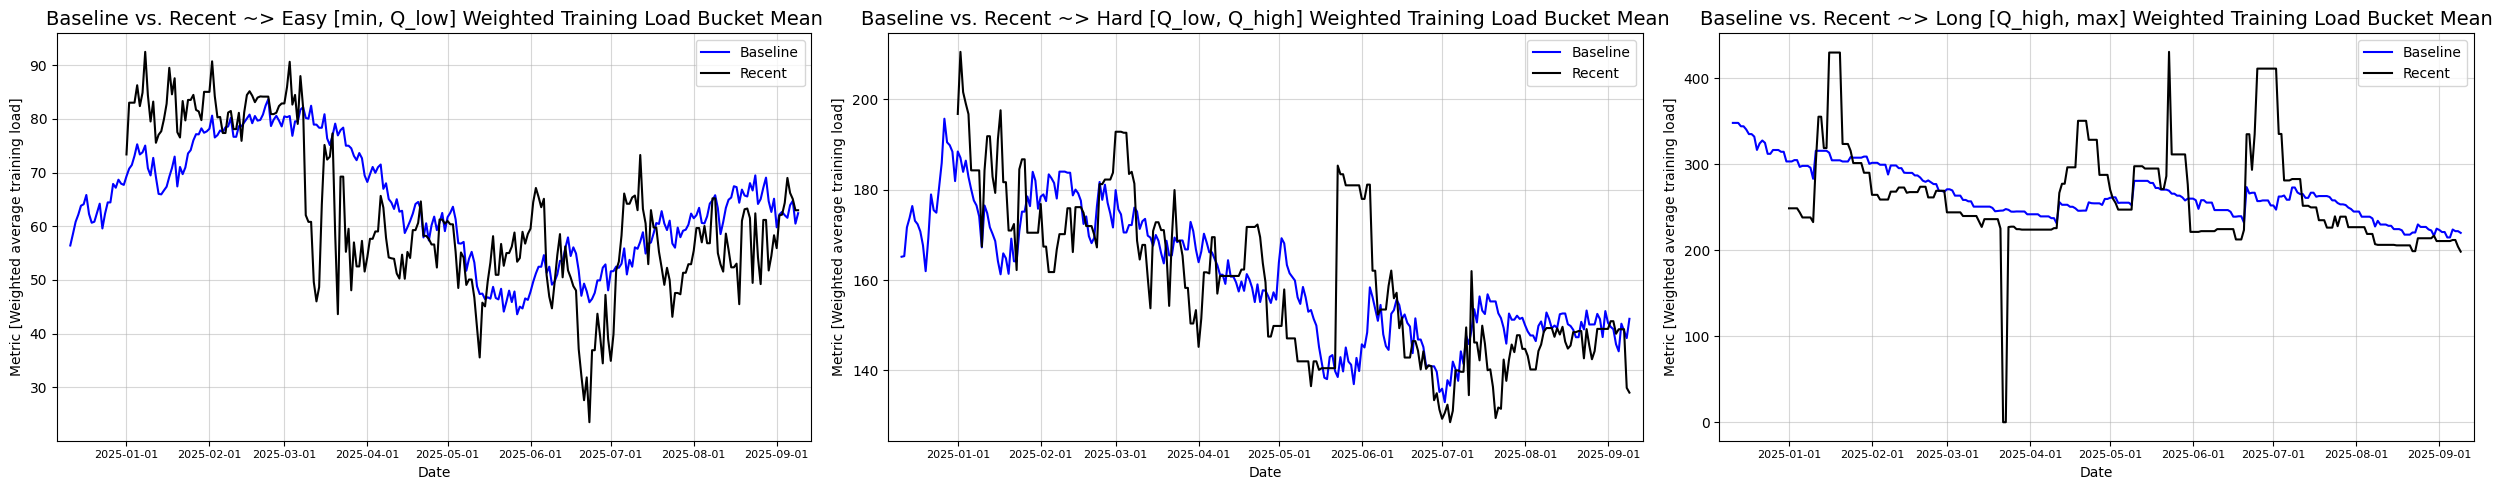

In [15]:
# Plots ~ Averages ~> Baseline vs. Recent

fig, ax = plt.subplots(1,3, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))
plot_data = rtl_data.loc[rtl_data["baseline_b1_TrainingLoad_weighted_mean"].notnull(), :]

ax[0].set_title("Baseline vs. Recent ~> Easy [min, Q_low] Weighted Training Load Bucket Mean", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b1_TrainingLoad_weighted_mean"], color="blue", label="Baseline")
ax[0].plot(plot_data["Datetime"], plot_data["recent_b1_TrainingLoad_weighted_mean"], color="black", label="Recent")

ax[1].set_title("Baseline vs. Recent ~> Hard [Q_low, Q_high] Weighted Training Load Bucket Mean", fontsize=14)
ax[1].plot(plot_data["Datetime"], plot_data["baseline_b2_TrainingLoad_weighted_mean"], color="blue", label="Baseline")
ax[1].plot(plot_data["Datetime"], plot_data["recent_b2_TrainingLoad_weighted_mean"], color="black", label="Recent")

ax[2].set_title("Baseline vs. Recent ~> Long [Q_high, max] Weighted Training Load Bucket Mean", fontsize=14)
ax[2].plot(plot_data["Datetime"], plot_data["baseline_b3_TrainingLoad_weighted_mean"], color="blue", label="Baseline")
ax[2].plot(plot_data["Datetime"], plot_data["recent_b3_TrainingLoad_weighted_mean"], color="black", label="Recent")

for i in [0,1,2]:
    ax[i].legend()
    ax[i].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=5)))
    # ax[i].set_ylim(-10, pd.concat([plot_data["baseline_b3_TrainingLoad_weighted_mean"], plot_data["recent_b3_TrainingLoad_weighted_mean"]]).max() + 15)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Metric [Weighted average training load]")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

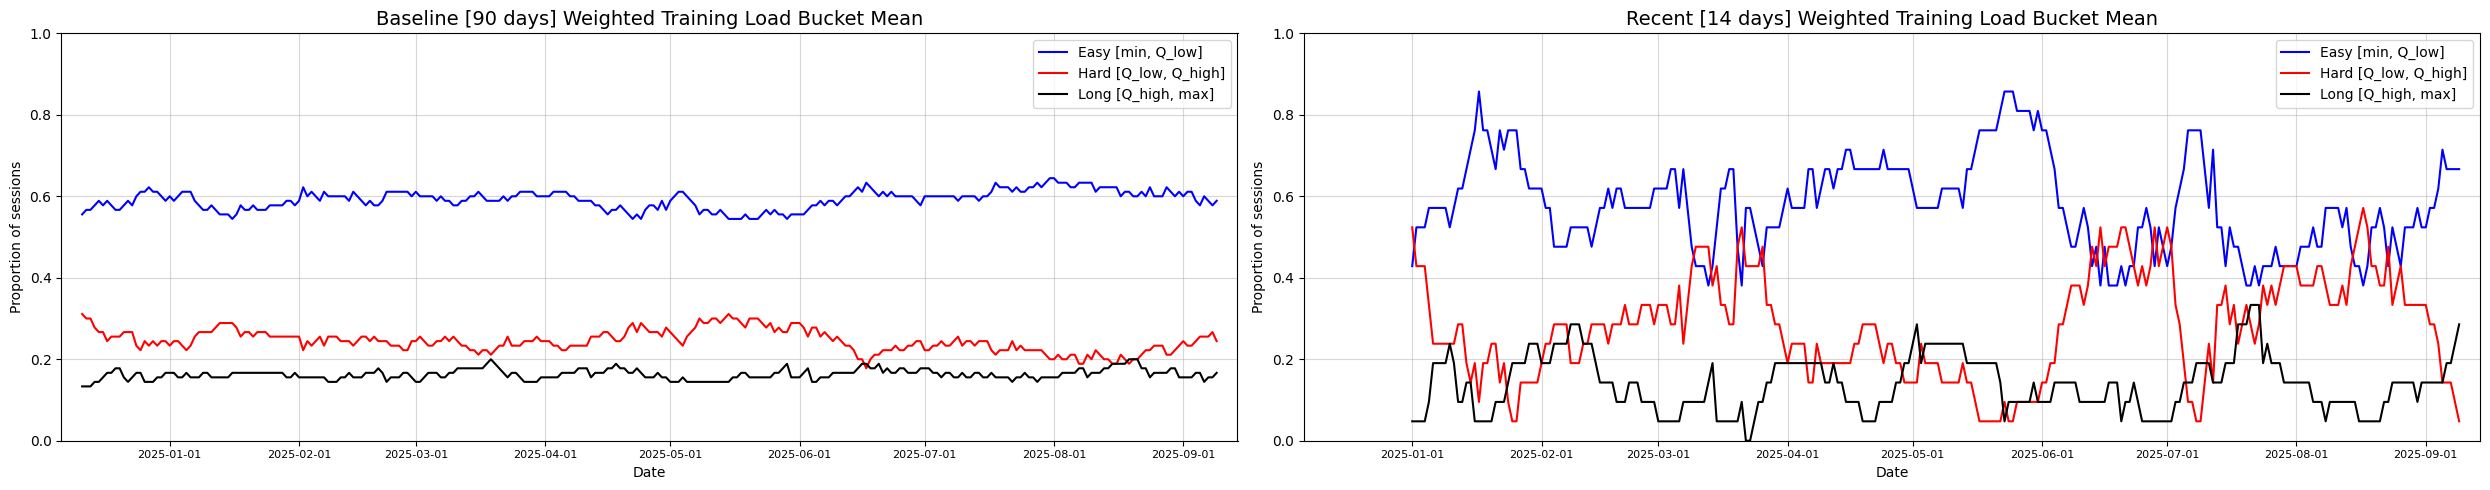

In [16]:
# Plots ~ Proportions ~> Baseline & Recent

fig, ax = plt.subplots(1,2, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))
plot_data = rtl_data.loc[rtl_data["baseline_b1_TrainingLoad_proportion"].notnull(), :]

ax[0].set_title("Baseline [90 days] Weighted Training Load Bucket Mean", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b1_TrainingLoad_proportion"], color="blue", label="Easy [min, Q_low]")
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b2_TrainingLoad_proportion"], color="red", label="Hard [Q_low, Q_high]")
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b3_TrainingLoad_proportion"], color="black", label="Long [Q_high, max]")

ax[1].set_title("Recent [14 days] Weighted Training Load Bucket Mean", fontsize=14)
ax[1].plot(plot_data["Datetime"], plot_data["recent_b1_TrainingLoad_proportion"], color="blue", label="Easy [min, Q_low]")
ax[1].plot(plot_data["Datetime"], plot_data["recent_b2_TrainingLoad_proportion"], color="red", label="Hard [Q_low, Q_high]")
ax[1].plot(plot_data["Datetime"], plot_data["recent_b3_TrainingLoad_proportion"], color="black", label="Long [Q_high, max]")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=5)))
    ax[i].set_ylim(0,1)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Proportion of sessions")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

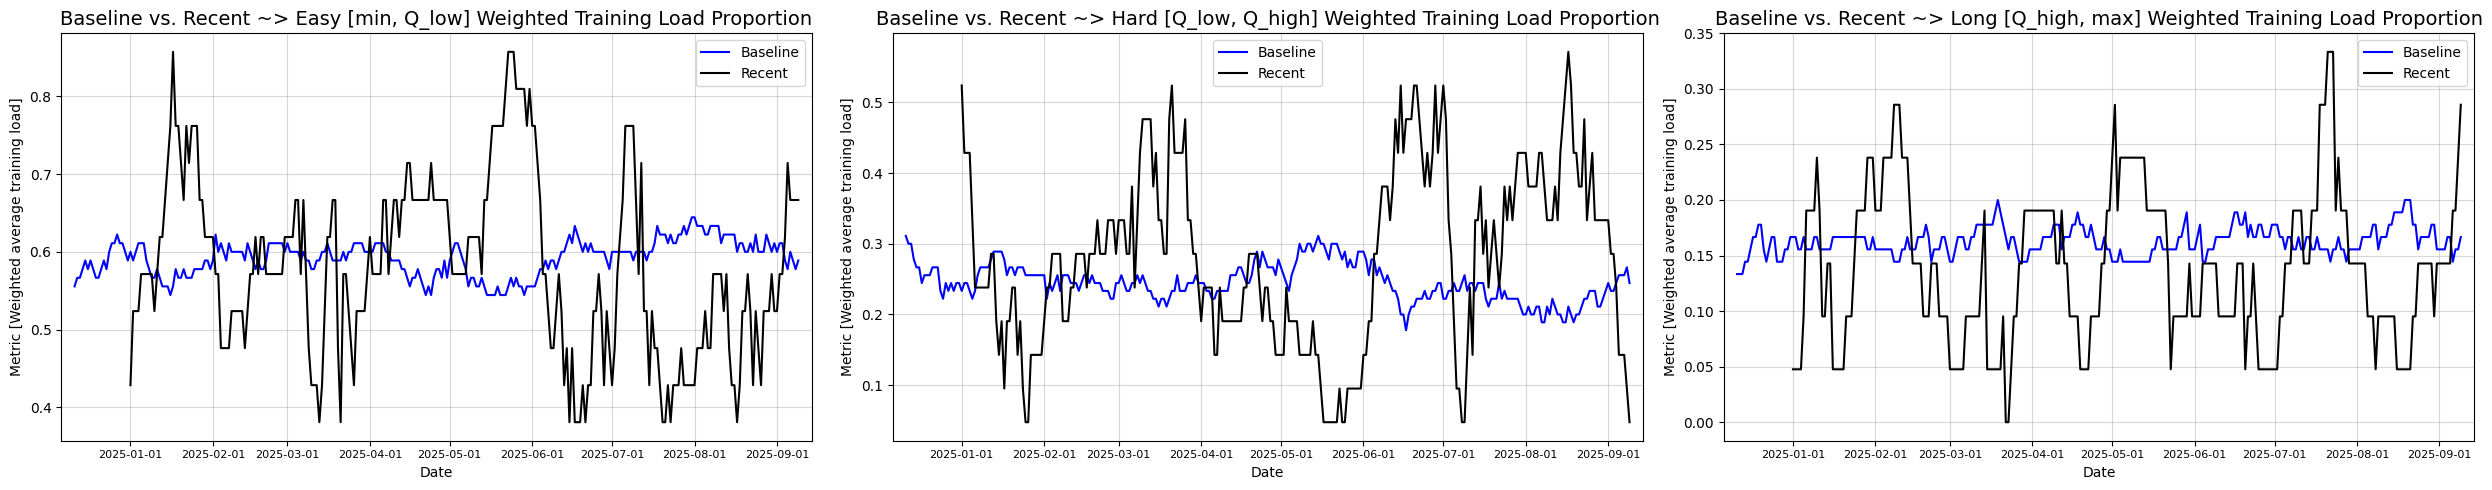

In [17]:
# Plots ~ Proportions ~> Baseline vs. Recent

fig, ax = plt.subplots(1,3, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))
plot_data = rtl_data.loc[rtl_data["baseline_b1_TrainingLoad_proportion"].notnull(), :]

ax[0].set_title("Baseline vs. Recent ~> Easy [min, Q_low] Weighted Training Load Proportion", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data["baseline_b1_TrainingLoad_proportion"], color="blue", label="Baseline")
ax[0].plot(plot_data["Datetime"], plot_data["recent_b1_TrainingLoad_proportion"], color="black", label="Recent")

ax[1].set_title("Baseline vs. Recent ~> Hard [Q_low, Q_high] Weighted Training Load Proportion", fontsize=14)
ax[1].plot(plot_data["Datetime"], plot_data["baseline_b2_TrainingLoad_proportion"], color="blue", label="Baseline")
ax[1].plot(plot_data["Datetime"], plot_data["recent_b2_TrainingLoad_proportion"], color="black", label="Recent")

ax[2].set_title("Baseline vs. Recent ~> Long [Q_high, max] Weighted Training Load Proportion", fontsize=14)
ax[2].plot(plot_data["Datetime"], plot_data["baseline_b3_TrainingLoad_proportion"], color="blue", label="Baseline")
ax[2].plot(plot_data["Datetime"], plot_data["recent_b3_TrainingLoad_proportion"], color="black", label="Recent")

for i in [0,1,2]:
    ax[i].legend()
    ax[i].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=5)))
    # ax[i].set_ylim(0,1)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Metric [Weighted average training load]")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

Once we have defined baseline and recent Stratified Load Averages (SLA) $\mu_{k,t}$ and $\nu_{k,t}$, where recent SLAs are computed using the baseline-defined buckets, we can perform a series of **bucket-level diagnostics** before constructing the final metric, the History-Aware Stratified Relative Training Load (HASRTL).

1. **Within-window SLA comparisons** 
By comparing SLAs within the same window (baseline and recent), we gain insight into the structure and balance of the training program. This allows us to evaluate whether the training is appropriately stratified across session types for optimal adaptation - for example, whether easy, hard, and long sessions clearly distinct, or if the load differences shrink, reducing meaningful variation for optimal adaptation? In practice, we compare SLAs pairwise:

$$\zeta_{\mu_i, \mu_j} = \frac{\mu_{i,t}}{\mu_{j,t}} \quad \text{and} \quad \zeta_{\nu_i, \nu_j} = \frac{\nu_{i,t}}{\nu_{j,t}}, \quad i,j = 1,2,3, i \neq j$$

2. **Recent vs. Baseline SLA comparisons**

Next, we can compare recent SLAs to baseline SLAs by bucket, using the baseline-defined thresholds to classify recent sessions. This reveals how training is evolving over time and identifies which types of sessions are driving changes in overall load.
For example, a rise in $\delta_{1,t}$ might indicate that easy sessions are becoming more demanding relative to the baseline, whereas an increase in $\delta_{3,t}$ would point to unusually high stress from long sessions.

$$\delta_{k,t} = \frac{\nu_{k,t}}{\mu_{k,t}}, \quad k = 1,2,3$$

3. **Recent vs. Baseline Proportion comparisons**

Similarly, we can track how the distribution of session types shifts from baseline to recent. For this, we define the relative proportion of recent to baseline for each bucket as: 

$$\rho_{k,t} = \frac{\pi_{k,t}^{(r)}}{\pi_{k,t}^{(b)}}, \quad k=1,2,3$$

For instance, $\rho_{1,t} < 1$ may indicate that recovery-oriented easy days are becoming too rare, while $\rho_{3,t} > 1$ suggests long, high-stress sessions are occurring more often than the body is adapted to.


Together, these diagnostics provide a detailed picture of training composition and evolution and form the foundation for interpreting the aggregated HASRTL metric.

In [18]:
# Within window SLA Comparison

# Within Baseline SLA
rtl_data["baseline_w_SLA_b2_b1"] = rtl_data["baseline_b2_TrainingLoad_weighted_mean"] / rtl_data["baseline_b1_TrainingLoad_weighted_mean"]
rtl_data["baseline_w_SLA_b3_b2"] = rtl_data["baseline_b3_TrainingLoad_weighted_mean"] / rtl_data["baseline_b2_TrainingLoad_weighted_mean"]
rtl_data["baseline_w_SLA_b3_b1"] = rtl_data["baseline_b3_TrainingLoad_weighted_mean"] / rtl_data["baseline_b1_TrainingLoad_weighted_mean"]

# Within Recent SLA
rtl_data["recent_w_SLA_b2_b1"] = rtl_data["recent_b2_TrainingLoad_weighted_mean"] / rtl_data["recent_b1_TrainingLoad_weighted_mean"]
rtl_data["recent_w_SLA_b3_b2"] = rtl_data["recent_b3_TrainingLoad_weighted_mean"] / rtl_data["recent_b2_TrainingLoad_weighted_mean"]
rtl_data["recent_w_SLA_b3_b1"] = rtl_data["recent_b3_TrainingLoad_weighted_mean"] / rtl_data["recent_b1_TrainingLoad_weighted_mean"]

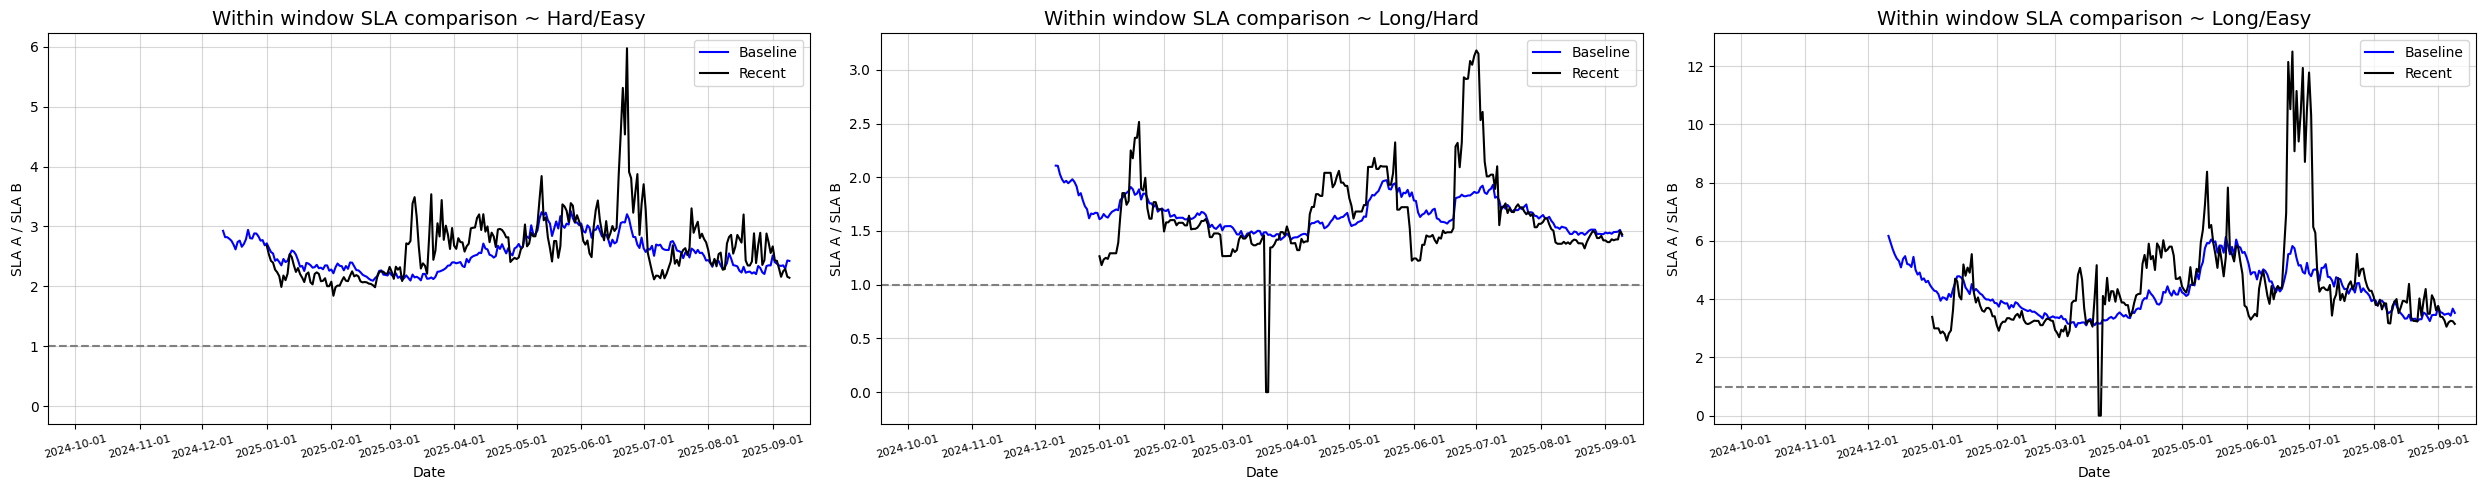

In [19]:
# Within window SLA Comparison ~ Plots

fig, ax = plt.subplots(1,3, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))

ax[0].set_title("Within window SLA comparison ~ Hard/Easy", fontsize=14)
ax[0].plot(rtl_data["Datetime"], rtl_data["baseline_w_SLA_b2_b1"], color="blue", label="Baseline")
ax[0].plot(rtl_data["Datetime"], rtl_data["recent_w_SLA_b2_b1"], color="black", label="Recent")

ax[1].set_title("Within window SLA comparison ~ Long/Hard", fontsize=14)
ax[1].plot(rtl_data["Datetime"], rtl_data["baseline_w_SLA_b3_b2"], color="blue", label="Baseline")
ax[1].plot(rtl_data["Datetime"], rtl_data["recent_w_SLA_b3_b2"], color="black", label="Recent")

ax[2].set_title("Within window SLA comparison ~ Long/Easy", fontsize=14)
ax[2].plot(rtl_data["Datetime"], rtl_data["baseline_w_SLA_b3_b1"], color="blue", label="Baseline")
ax[2].plot(rtl_data["Datetime"], rtl_data["recent_w_SLA_b3_b1"], color="black", label="Recent")

for i in [0,1,2]:
    ax[i].legend()
    ax[i].axhline(y=1, color="grey", linestyle="--")
    ax[i].set_xlim(np.min(rtl_data["Datetime"]) + datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=10)))
    ax[i].set_ylim(-0.3)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("SLA A / SLA B")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=15, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [20]:
# Recent vs. Baseline SLA Comparison

rtl_data["SLA_b1"] = rtl_data["recent_b1_TrainingLoad_weighted_mean"] / rtl_data["baseline_b1_TrainingLoad_weighted_mean"] # Easy [min, Q70]
rtl_data["SLA_b2"] = rtl_data["recent_b2_TrainingLoad_weighted_mean"] / rtl_data["baseline_b2_TrainingLoad_weighted_mean"] # Hard [Q70, Q90]
rtl_data["SLA_b3"] = rtl_data["recent_b3_TrainingLoad_weighted_mean"] / rtl_data["baseline_b3_TrainingLoad_weighted_mean"] # Long [Q90, max]

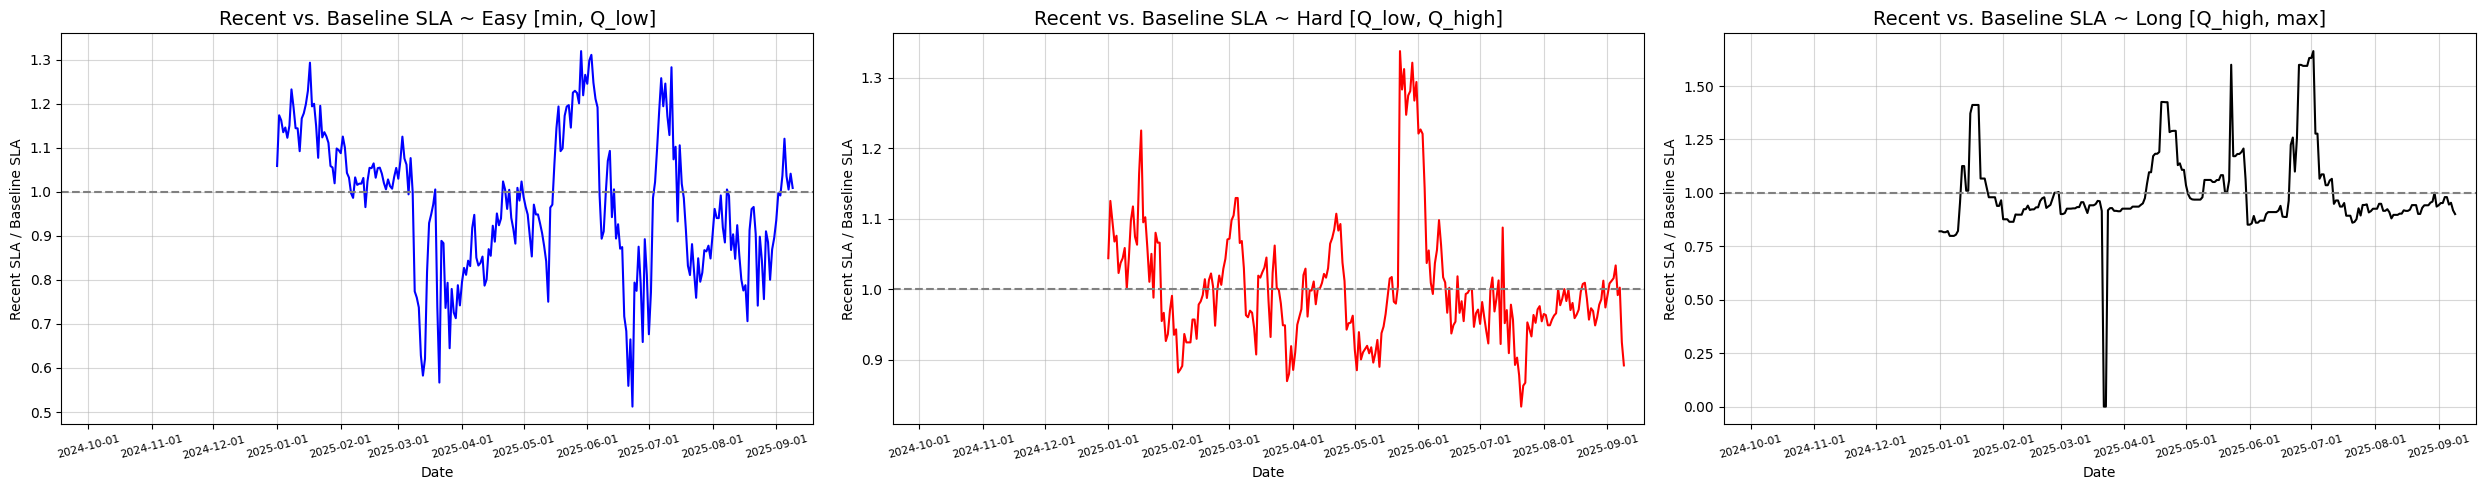

In [21]:
# Recent vs. Baseline SLA Comparison ~ Plots

fig, ax = plt.subplots(1,3, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))

ax[0].set_title("Recent vs. Baseline SLA ~ Easy [min, Q_low]", fontsize=14)
ax[0].plot(rtl_data["Datetime"], rtl_data["SLA_b1"], color="blue", label="Recent/Baseline")

ax[1].set_title("Recent vs. Baseline SLA ~ Hard [Q_low, Q_high]", fontsize=14)
ax[1].plot(rtl_data["Datetime"], rtl_data["SLA_b2"], color="red", label="Recent/Baseline")

ax[2].set_title("Recent vs. Baseline SLA ~ Long [Q_high, max]", fontsize=14)
ax[2].plot(rtl_data["Datetime"], rtl_data["SLA_b3"], color="black", label="Recent/Baseline")

for i in [0,1,2]:
    ax[i].axhline(y=1, color="grey", linestyle="--")
    ax[i].set_xlim(np.min(rtl_data["Datetime"]) + datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=10)))
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Recent SLA / Baseline SLA")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=15, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
# Recent vs. Baseline proportions Comparison

rtl_data["relative_proportion_b1"] = rtl_data["recent_b1_TrainingLoad_proportion"] / rtl_data["baseline_b1_TrainingLoad_proportion"] # Easy [min, Q70]
rtl_data["relative_proportion_b2"] = rtl_data["recent_b2_TrainingLoad_proportion"] / rtl_data["baseline_b2_TrainingLoad_proportion"] # Hard [Q70, Q90]
rtl_data["relative_proportion_b3"] = rtl_data["recent_b3_TrainingLoad_proportion"] / rtl_data["baseline_b3_TrainingLoad_proportion"] # Long [Q90, max]

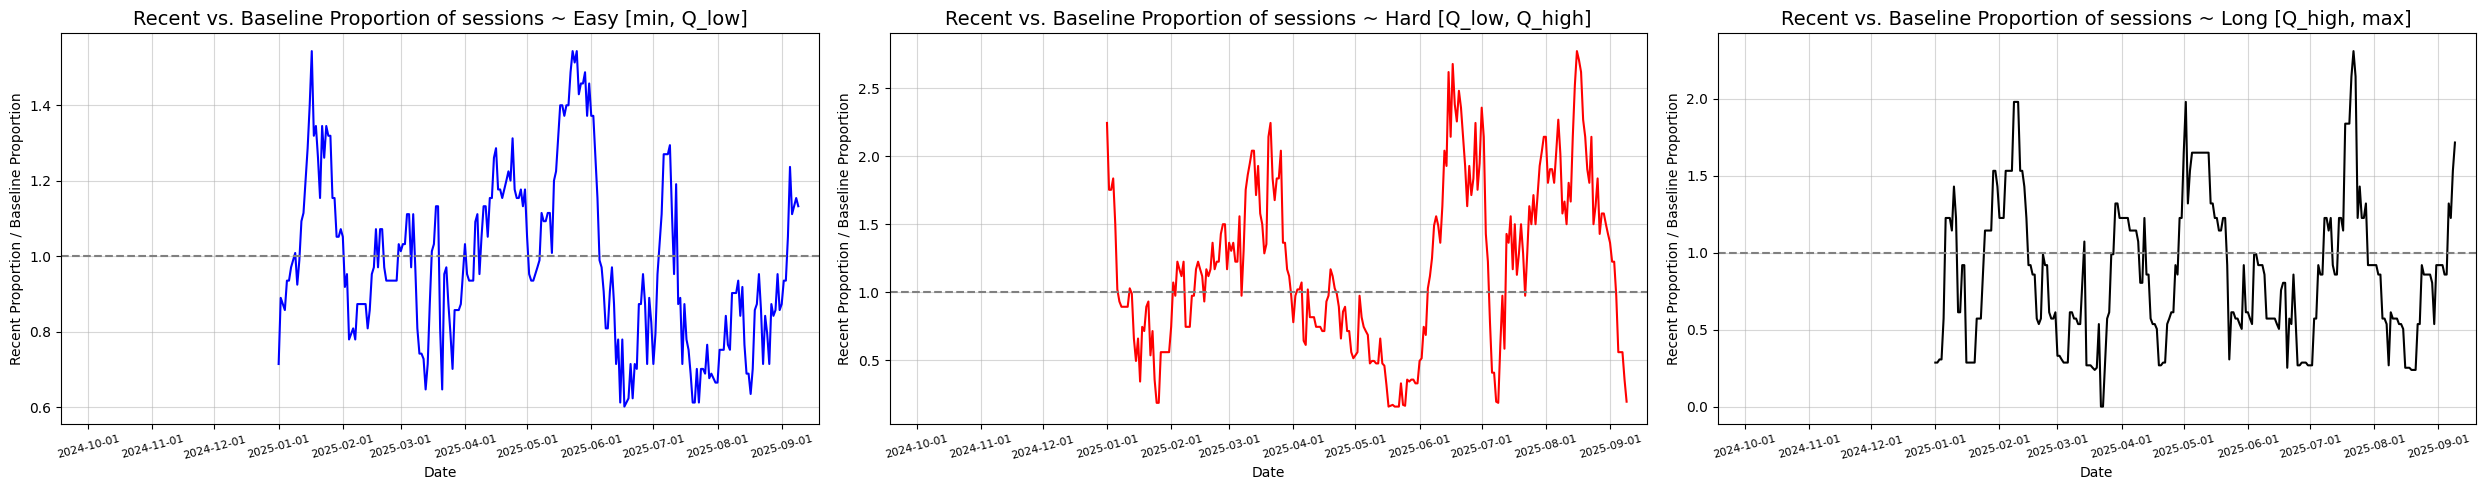

In [23]:
# Recent vs. Baseline proportions Comparison ~ Plots

fig, ax = plt.subplots(1,3, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))

ax[0].set_title("Recent vs. Baseline Proportion of sessions ~ Easy [min, Q_low]", fontsize=14)
ax[0].plot(rtl_data["Datetime"], rtl_data["relative_proportion_b1"], color="blue", label="Recent/Baseline")

ax[1].set_title("Recent vs. Baseline Proportion of sessions ~ Hard [Q_low, Q_high]", fontsize=14)
ax[1].plot(rtl_data["Datetime"], rtl_data["relative_proportion_b2"], color="red", label="Recent/Baseline")

ax[2].set_title("Recent vs. Baseline Proportion of sessions ~ Long [Q_high, max]", fontsize=14)
ax[2].plot(rtl_data["Datetime"], rtl_data["relative_proportion_b3"], color="black", label="Recent/Baseline")

for i in [0,1,2]:
    ax[i].axhline(y=1, color="grey", linestyle="--")
    ax[i].set_xlim(np.min(rtl_data["Datetime"]) + datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=10)))
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Recent Proportion / Baseline Proportion")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=15, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

**Defining the History-Aware Stratified Relative Training Load (HASRTL)**

Once training sessions are divided into the three percentile-based buckets, defined from the baseline window,, we can combine them into a single, interpretable metric that reflects how recent training compares to the athlete’s long-term adaptation. The central idea is weighted aggregation, where each bucket contributes differently to the overall metric:

- **Easy sessions**: Frequent but low-stress. Weight reflects their cumulative impact on overall load.
- **Hard sessions**: Less frequent but higher intensity. Weight reflects their contribution to acute stress.
- **Long days**: Rare but highly taxing. Weight reflects their peak stress contribution.

By aggregating the per-bucket loads with appropriate weights, HASRTL produces a single number that reflects how the overall recent training load compares to the baseline adaptation. Also, because the metric is built from the individual buckets, as we have seen above, we can inspect each session type separately to see which types of workouts are driving increases or spikes.

**Weighted aggregation**

Let $w_1, w_2, w_3$ denote weights for easy, hard, and long sessions, respectively, with $$w_1+w_2+w_3=1,\quad w_k\ge 0$$
The baseline aggregate load is then: $$ TL_{\text{baseline},t} = w_1 \mu_{1,t} + w_2 \mu_{2,t} + w_3 \mu_{3,t} $$
Similarly, the recent aggregate load is: $$ TL_{\text{recent},t} = w_1 \nu_{1,t} + w_2 \nu_{2,t} + w_3 \nu_{3,t} $$

Finally, the **History-Aware Stratified Relative Training Load (HASRTL)** is defined as:

$$\Delta_t = \frac{TL_{\text{recent}}}{TL_{\text{baseline}}}$$

- $\Delta_t > 1$ indicates that recent training exceeds the baseline adaptation.
- $\Delta_t < 1$ indicates that recent training is below the baseline.

Note: Since recent sessions are classified using baseline-defined buckets, $\Delta_t$ represents the relative training load compared to what the athlete has already adapted to, making it a robust measure of both increased stress and potential risk.

**Selection weights $w_1, w_2, w_3$**

When defining the buckets weights, for our purpose, we have to consider the bucket's contribution to adaptation and also their potential impact on injury risk. The weights should reflect the relative importance of bucket's session type in promoting positive training effects while also accounting for their role in acute stress spikes that may increase the probability of injury.

- Easy sessions: As we defined them, they are frequent and involve low-intensity activities. They have low impact on both the adaptation and injury risk.
    - $w_1 = 0.15$
- Hard sessison: Less frequent but high-intensity activities that drive the adaptation and also impose higher acute loads that increase injury risk. 
    - $w2 = 0.40$
- Long sessison: They are rare but lead to high cumulative stress. They significantly contribute to adaptation and also pose a highest risk of injury
    - $w3: = 0.45$

In [24]:
# Define HASTRL weights
hastrl_weight_b1 = 0.15
hastrl_weight_b2 = 0.45
hastrl_weight_b3 = 0.4

In [25]:
# HASTRL calculation

# TL Baseline
rtl_data["TL_baseline"] = (
    hastrl_weight_b1 * rtl_data["baseline_b1_TrainingLoad_weighted_mean"] + 
    hastrl_weight_b2 * rtl_data["baseline_b2_TrainingLoad_weighted_mean"] +
    hastrl_weight_b3 * rtl_data["baseline_b3_TrainingLoad_weighted_mean"]
    )

# TL Recent
rtl_data["TL_recent"] = (
    hastrl_weight_b1 * rtl_data["recent_b1_TrainingLoad_weighted_mean"] + 
    hastrl_weight_b2 * rtl_data["recent_b2_TrainingLoad_weighted_mean"] +
    hastrl_weight_b3 * rtl_data["recent_b3_TrainingLoad_weighted_mean"]
    )

# HASTRL 
rtl_data["HASTRL"] = rtl_data["TL_recent"] / rtl_data["TL_baseline"]

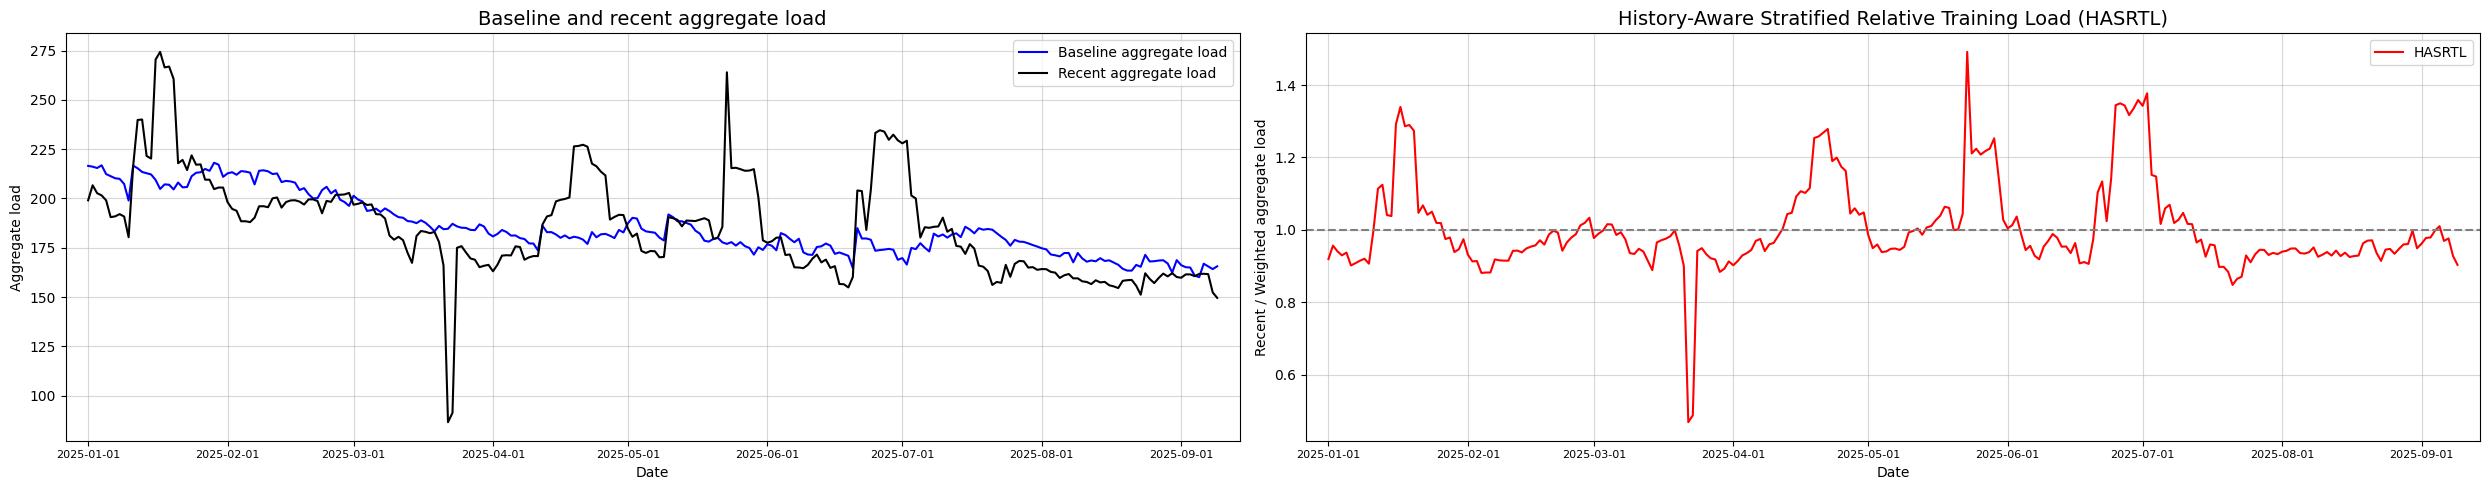

In [26]:
# HASTRL plots

# Plots ~ Averages ~> Baseline & Recent

fig, ax = plt.subplots(1,2, figsize=(25,5))
indices = np.arange(0, len(rtl_data["Datetime"]))
plot_data = rtl_data.loc[rtl_data["HASTRL"].notnull(), :]

ax[0].set_title("Baseline and recent aggregate load", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data["TL_baseline"], color="blue", label="Baseline aggregate load")
ax[0].plot(plot_data["Datetime"], plot_data["TL_recent"], color="black", label="Recent aggregate load")
ax[0].set_ylabel("Aggregate load")

ax[1].set_title("History-Aware Stratified Relative Training Load (HASRTL)", fontsize=14)
ax[1].plot(plot_data["Datetime"], plot_data["HASTRL"], color="red", label="HASRTL")
ax[1].axhline(y=1, color="grey", linestyle="--")
ax[1].set_ylabel("Recent / Weighted aggregate load")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(rtl_data["Datetime"] + datetime.timedelta(days=5)))
    ax[i].set_xlabel("Date")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())  
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [27]:
rtl_data

,Datetime,Training load,Distance [km],Duration [h],Activity type,Description,Date index,easy_hard_long_description,baseline_b1_TrainingLoad_weighted_mean,baseline_b2_TrainingLoad_weighted_mean,baseline_b3_TrainingLoad_weighted_mean,baseline_b1_TrainingLoad_proportion,baseline_b2_TrainingLoad_proportion,baseline_b3_TrainingLoad_proportion,recent_b1_TrainingLoad_weighted_mean,recent_b2_TrainingLoad_weighted_mean,recent_b3_TrainingLoad_weighted_mean,recent_b1_TrainingLoad_proportion,recent_b2_TrainingLoad_proportion,recent_b3_TrainingLoad_proportion,baseline_w_SLA_b2_b1,baseline_w_SLA_b3_b2,baseline_w_SLA_b3_b1,recent_w_SLA_b2_b1,recent_w_SLA_b3_b2,recent_w_SLA_b3_b1,SLA_b1,SLA_b2,SLA_b3,relative_proportion_b1,relative_proportion_b2,relative_proportion_b3,TL_baseline,TL_recent,HASTRL
0,2024-09-13,129.8,10.8,1.29,Trail Running,Moravce Trail Running,362,easy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-09-14,48.5,9.2,1.46,Trail Running,Kamnik - DT/hike 90' + PWH 2x20' press la,361,hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-09-15,229.8,86.6,2.93,Road Biking,Moravce Road Biking,360,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-09-16,140.9,12.2,0.90,Running,"Kranj - INT micro 2x 30/15, RPE, auto la",359,hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-09-17,119.0,10.8,0.83,Running,Moravce - Aerobni tek + visoka kadenca 5x5,358,easy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-09-18,136.3,14.8,1.32,Trail Running,Moravce - INT 2-3-2-3-2',357,hard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-09-19,0.0,47.8,2.00,Indoor Biking,Slope Workout,356,easy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-09-20,126.4,11.9,1.21,Trail Running,Moravce Trail Running,355,easy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-09-21,287.8,23.7,2.37,Trail Running,"Mali Losinj - DT + TT 3x10' RPE, press lap",354,long,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-09-22,194.7,81.2,2.88,Road Biking,Mali Losinj Road Biking,353,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
